Due to the chosen bluffness ratio, the nose cone length was reduced to 0.12993613702390217 m.


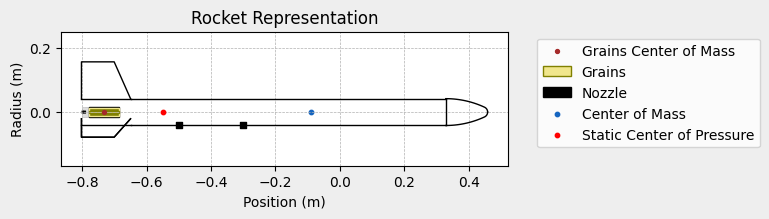


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 4.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.916 | e1: -0.121 | e2: 0.050 | e3: 0.379
Euler Angles - Spin φ : 45.00° | Nutation θ: -15.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 5.510 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 1.5 m
Launch Rail Inclination: 75.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.350 s
Rail Departure Velocity: 6.353 m/s
Rail Departure Stability Margin: 5.549 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 3.137
Rail Departure Reynolds Number: 3.622e+04


Burn out State

Burn out time: 5.300 s
Altitude at burn out: 141.755 m (ASL) | 137.755 m (AGL)
Rocket speed at burn out: 20.025 m/s
Freestream velocity a

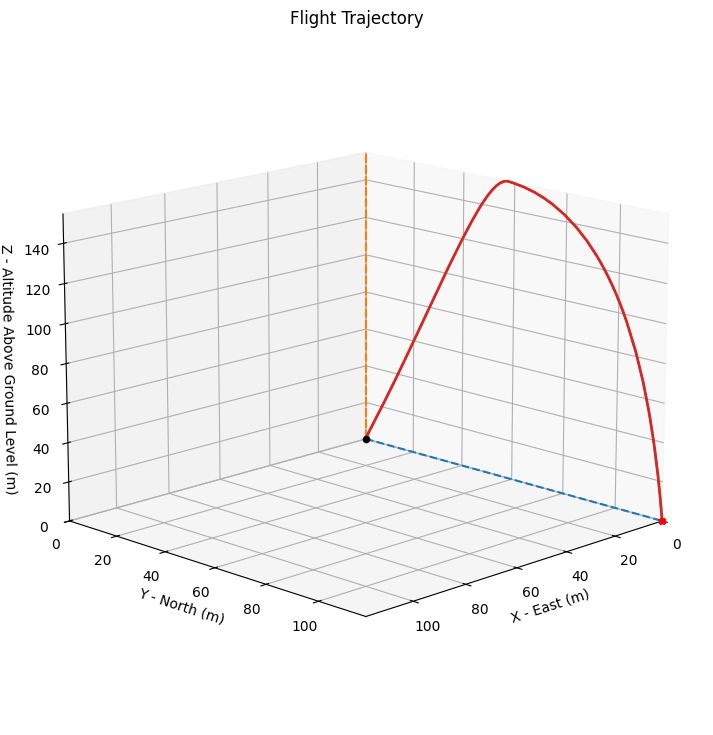



Trajectory Kinematic Plots



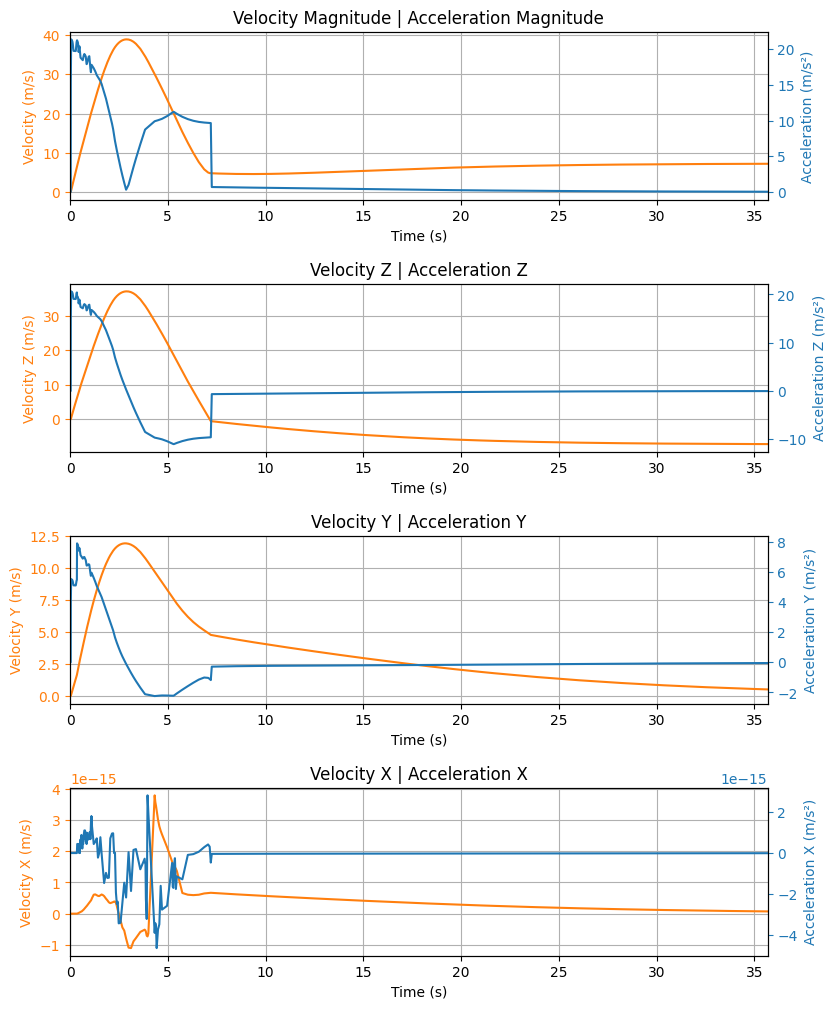



Angular Position Plots



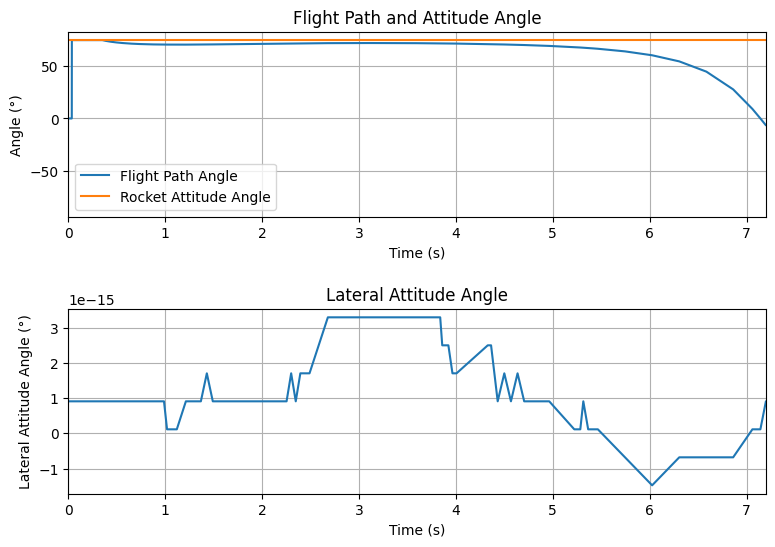



Path, Attitude and Lateral Attitude Angle plots



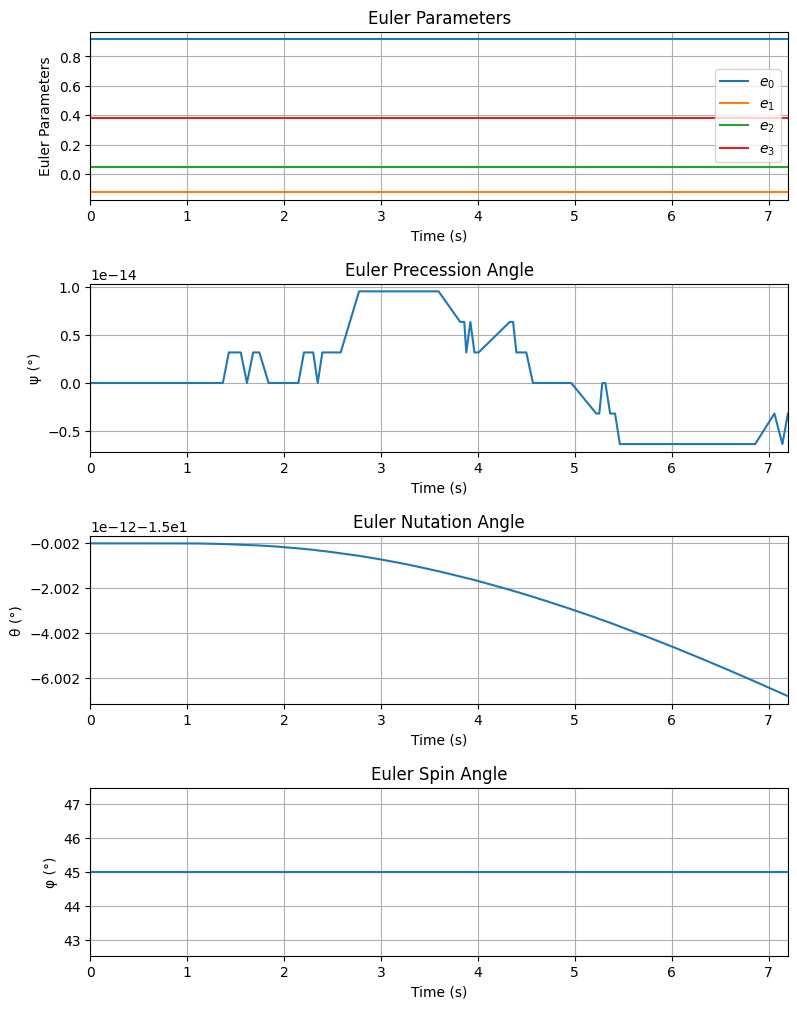



Trajectory Angular Velocity and Acceleration Plots



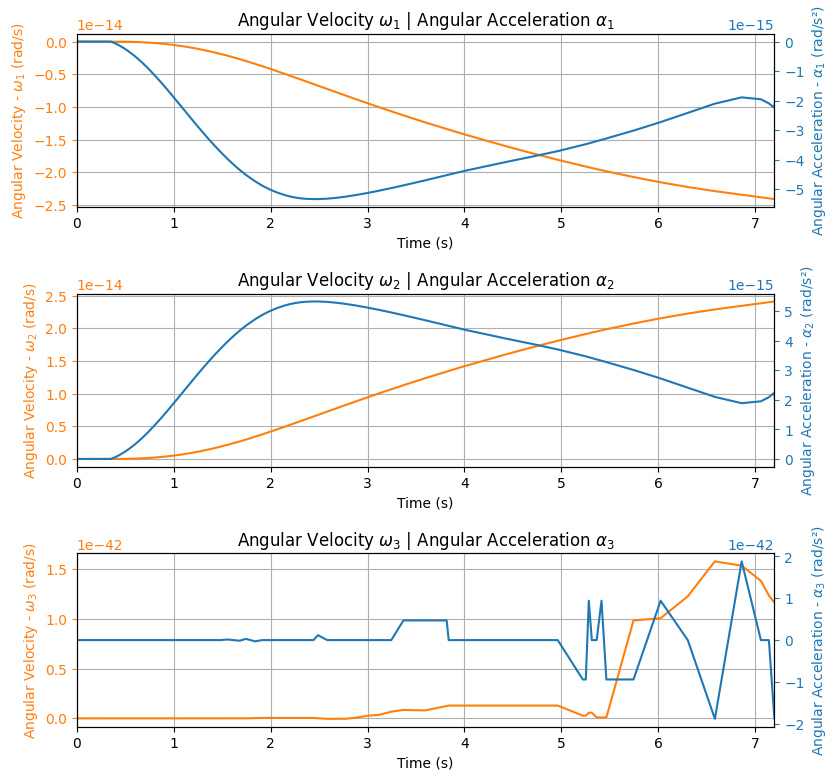



Aerodynamic Forces Plots



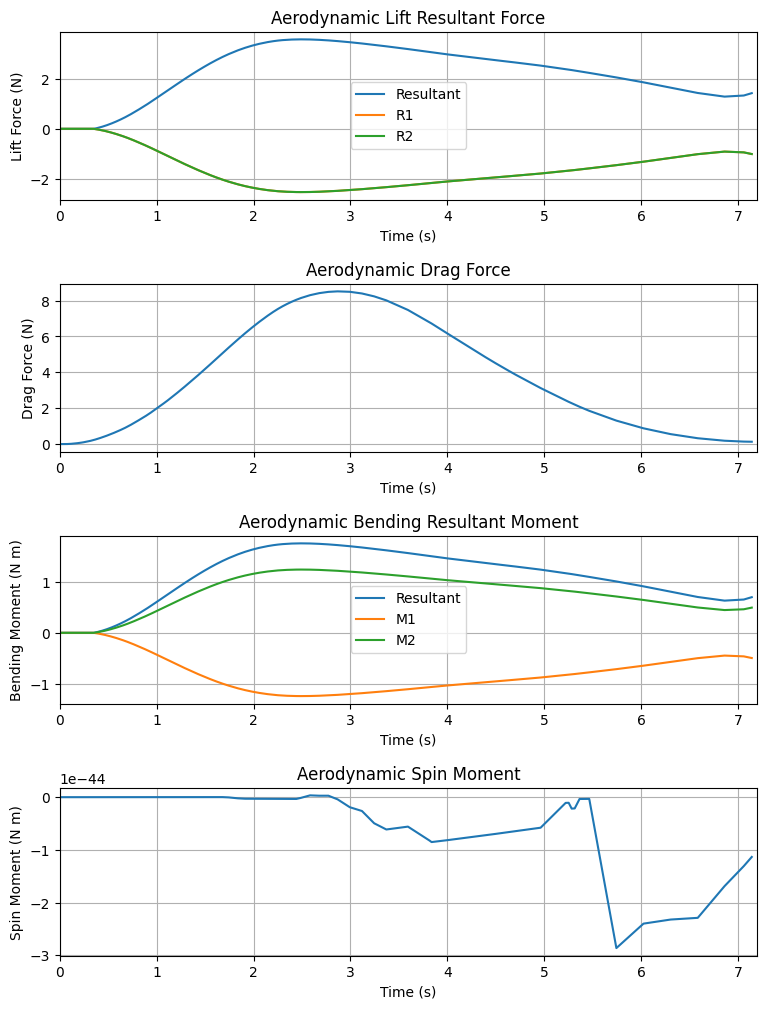



Rail Buttons Forces Plots



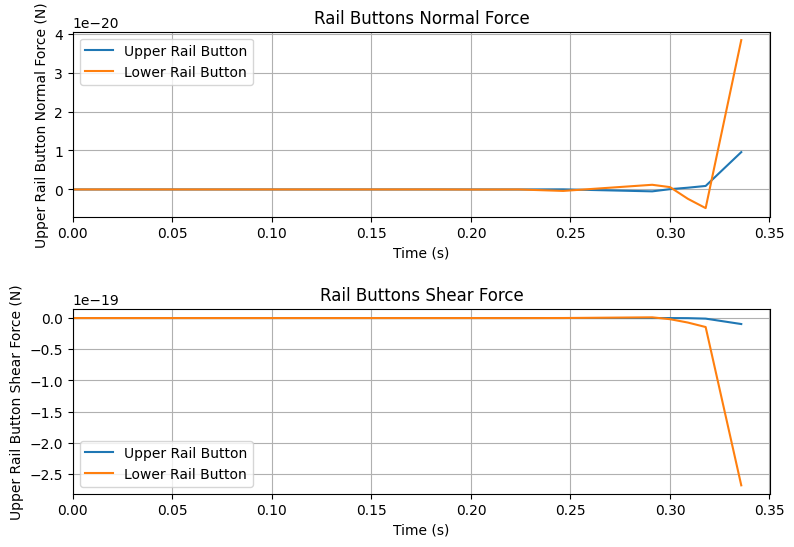



Trajectory Energy Plots



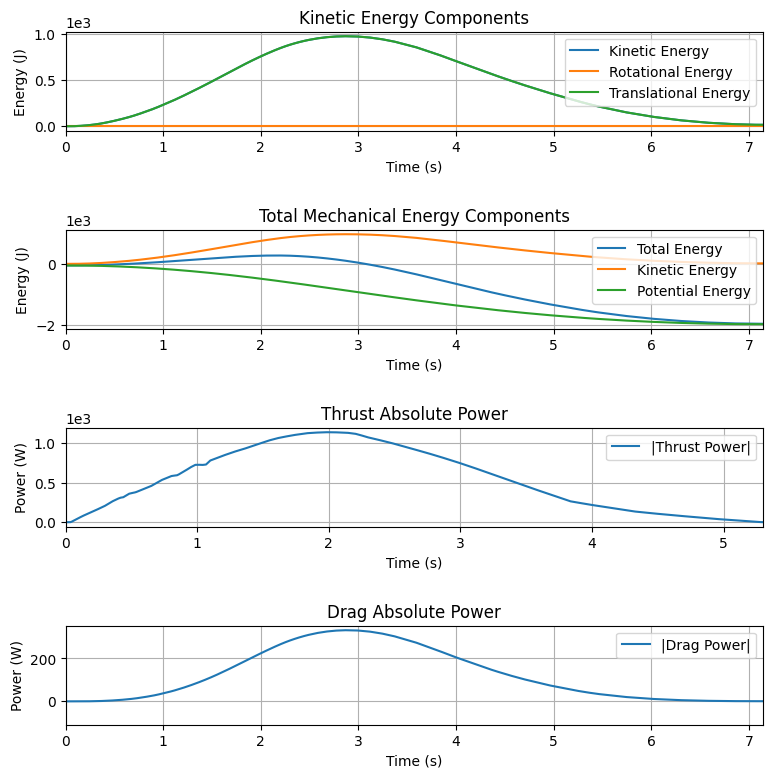



Trajectory Fluid Mechanics Plots



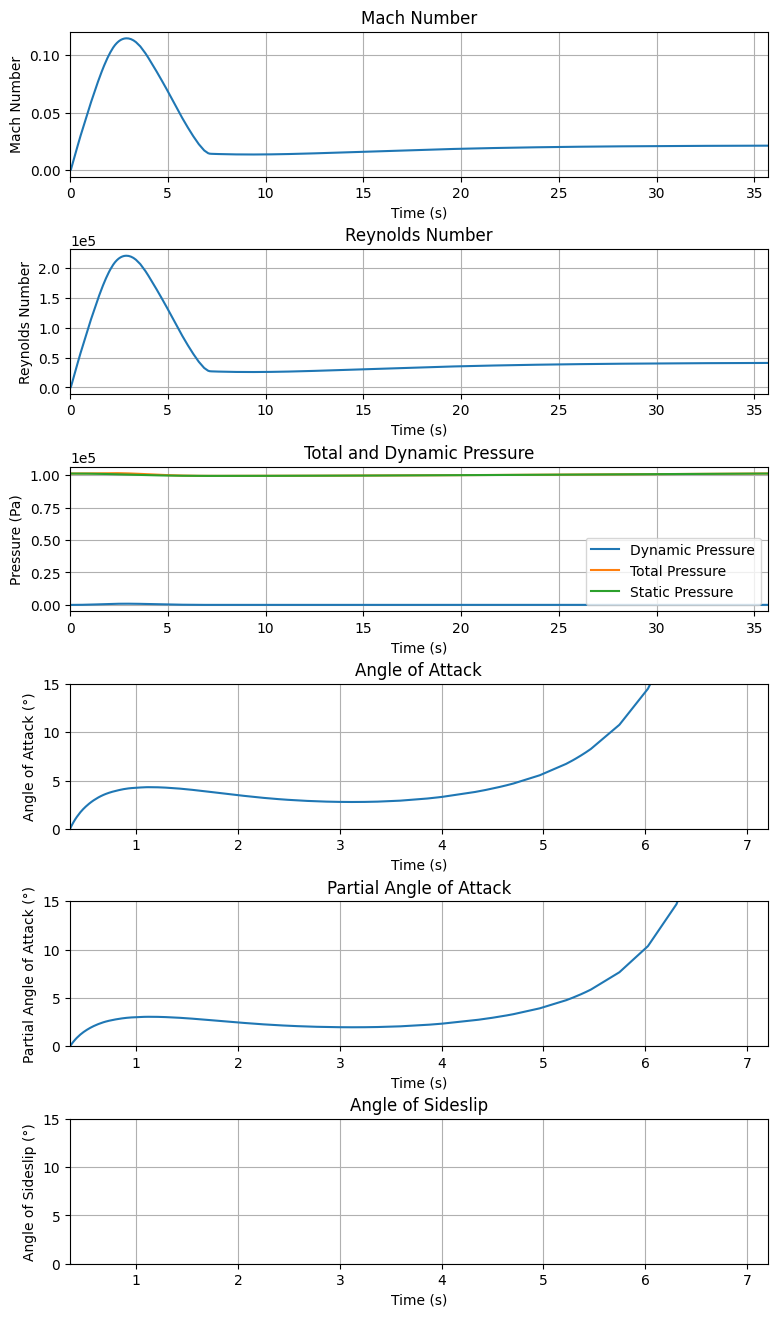



Trajectory Stability and Control Plots



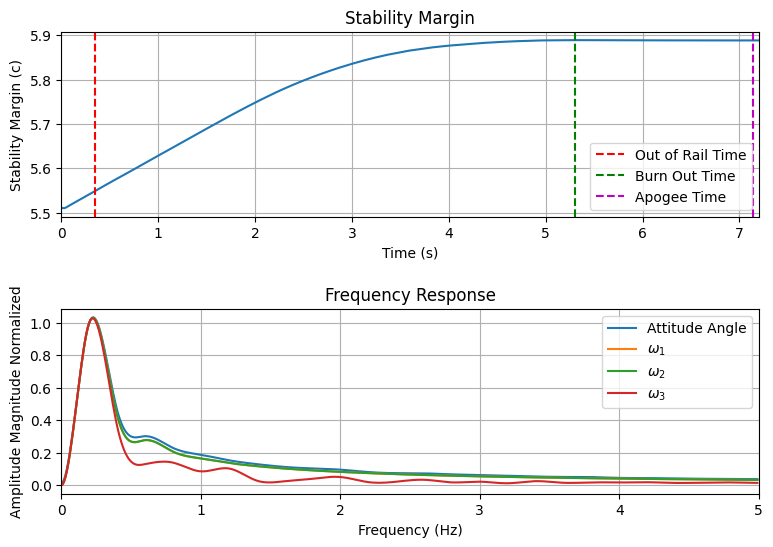



Rocket and Parachute Pressure Plots



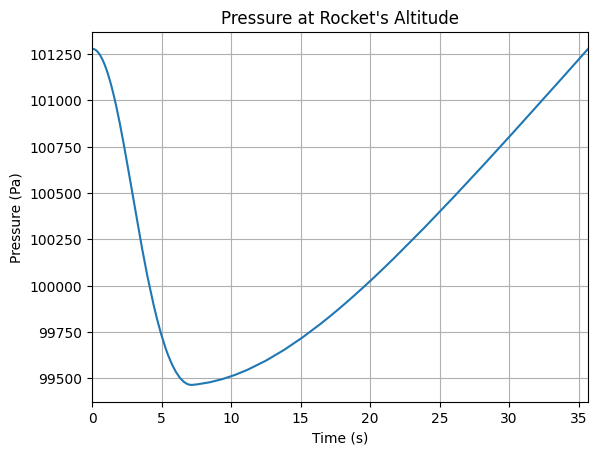


Parachute:  main


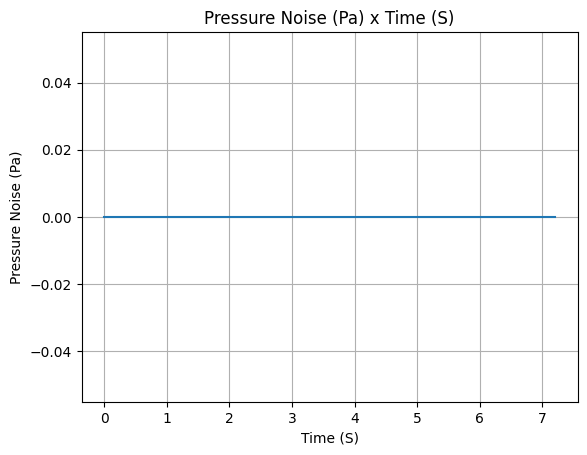

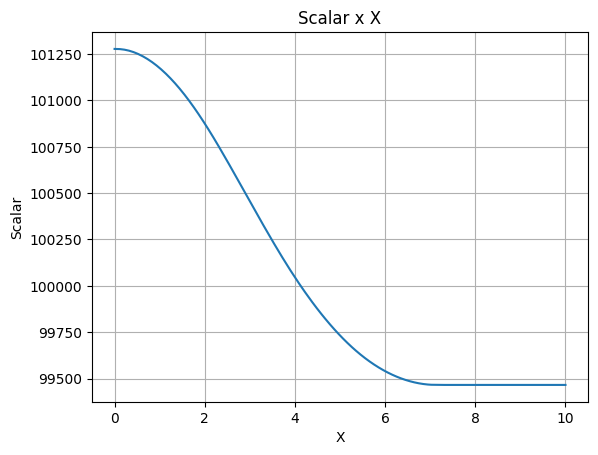

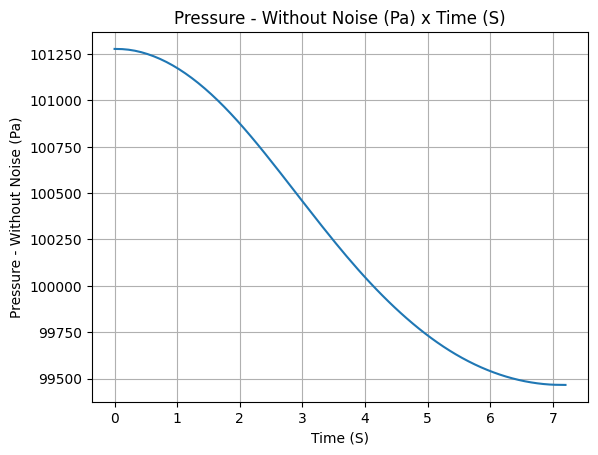

In [25]:
# Libraries
from rocketpy import Environment, SolidMotor, Rocket, Flight
import math

# Construct Launch Site Environment
launch_site = Environment(
    latitude=(27 + (55/60) + (58/3600)), # [deg] positive corresponds to North
    longitude=-(80 + (42/60) + (30/3600)), # [deg] positive corresponds to East
    elevation=4 # [m] launch site elevation above sea level
)

# AeroTech-G25W Motor Characteristics
propellant_length=0.09235 # [m] length of propellant grain
propellant_OD=0.02355 # [m] outer diameter of propellant grain
propellant_ID=0.00608 # [m] diameter of propellant core
propellant_mass=62.5/1000 # [kg] mass of propellant

nozzle_length=0.0224 # [m] nozzle length (measured from exit plane to plane abutting propellant grain)

CG_position_dry=0.07309 # [m] positiion of motor CG without propellant (relative to nozzle exit plane)

# Construct AeroTechG25W Solid Rocket Motor
AeroTechG25W = SolidMotor(
    thrust_source="AeroTechG25W_thrustcurve.csv", # [s, N]
    dry_mass=101.72/1000, # [kg]
    dry_inertia=(235307.21/(10**(-9)), 235307.21/(10**(-9)), 13414.14/(10**(-9))), # [kg*m^2] motor's dry mass inertia tensor components (e_3 = rocket symmetry axis)
    nozzle_radius=7.70/2/1000, # [m] nozzle exit radius
    grain_number=1, # [unitless]
    grain_density=propellant_mass/(propellant_length*(math.pi*(propellant_OD/2)**2 - math.pi*(propellant_ID/2)**2)), # [kg/m^2]
    grain_outer_radius=propellant_OD/2, # [m]
    grain_initial_inner_radius=propellant_ID/2, # [m]
    grain_initial_height=propellant_length, # [m]
    grain_separation=0, # [m] all one propellant grain
    grains_center_of_mass_position=nozzle_length + (propellant_length/2), # [m]
    center_of_dry_mass_position=CG_position_dry, # [m]
    nozzle_position=0.0, # [m] position of nozzle exit area, relative to motor coordinate system origin
    burn_time=None, # [s] derived from `thrust_source`
    throat_radius=3.56/2/1000, # [m] radius of nozzle throat
    reshape_thrust_curve=False,
    interpolation_method="linear",
    coordinate_system_orientation="nozzle_to_combustion_chamber" # direction of positive coordinate system axis
)

# Rocket Characteristics
allowable_mass = 1.5 # [kg] maximum allowable rocket mass per 14 CFR Part 101.22
motor_mass = 2*(AeroTechG25W.propellant_initial_mass + AeroTechG25W.dry_mass) # [kg] total mass of both motors

# Construct Rocket
DART_rocket = Rocket(
    radius=(3.28/2*25.4)/1000, # [m] largest outer radius
    mass=allowable_mass - motor_mass, # [kg] dry mass of the rocket
    inertia=(0.273645, 0.273645, 0.004784), # [kg*m^2] rocket inertia tensor components (e_3 = rocket symmetry axis)
    power_off_drag=1.6939, # [unitless] C_D without motor firing
    power_on_drag=1.6939, # [unitless] C_D with motor firing
    center_of_mass_without_motor=0, # [m] position of the rocket CG w/o motors relative to the rocket's coordinate system
    coordinate_system_orientation="tail_to_nose" # direction of positive coordinate system axis
)

'''
-------------------- Add Ascent Motor --------------------
postion: [m] Position of the motor's coordinate system origin relative to the user defined rocket coordinate system
'''
DART_rocket.add_motor(AeroTechG25W, position=-0.8) # POSITION ARBITRARILY SET AND NEEDS TO BE UPDATED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


'''
-------------------- Add Rail Buttons --------------------
upper_button_position: Position of the rail button furthest from the nozzle relative to the rocket's coordinate system
lower_button_position: Position of the rail button closest to the nozzle relative to the rocket's coordinate system
'''
DART_rocket.set_rail_buttons(upper_button_position=-0.3, lower_button_position=-0.5) # [ARBITRARILY CHOSEN AND NEEDS TO BE UPDATED] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

'''
-------------------- Add Nose Cone --------------------
length: [m] length of the nose cone (excluding the shoulder)
kind: One of {Von Karman, conical, ogive, lvhaack, powerseries}
position: [m] Nose cone tip coordinate relative to the rocket's coordinate system
'''
DART_rocket.add_nose(length=5.85*0.0254, kind="ogive", position=0.459, bluffness=0.6/1.5)

# Construct Fins
DART_fins = DART_rocket.add_trapezoidal_fins(
    n=3, # [unitless] number of fins
    root_chord=6*0.0254, # [m]
    tip_chord=4*0.0254, # [m]
    span=4.5*0.0254, # [m]
    position=-0.65, # [m]
    cant_angle=0, # [deg] cant (i.e., tilt) angle of fins (non-zero will induce roll)
    airfoil=("NACA0012.csv", "degrees"), # [CSV of {alpha,C_L}, alpha provided in degrees]
)

# Parachute Characteristics
C_D = 0.84 # [unitless] parachute drag coefficient
parachute_reference_area=math.pi*(30*0.0254/2)**2 # [m^2] reference area of parachute

# Construct Parachute
main = DART_rocket.add_parachute(
    name="main", # name of the parachute (no impact on simulation)
    cd_s=C_D*parachute_reference_area, # [m^2] drag coefficient times parachute reference area
    trigger="apogee", # will trigger the parachute deployment at apogee (can also use a callable function based on fresstream pressure, altitude, and state vector)
    sampling_rate=10, # [Hz] sampling rate in which the trigger function works (used to simulate sensor refresh rates)
    lag=0, # [s] time between the ejection system is triggers and the parachute is fully opened (SHOULD BE QUANTIFIED WITH EJECTION TESTING)
    noise=(0,0,0) # [Pa] (mean, standard deviation, time-correlatio) used to add noise to the pressure signal
)

flight_test = Flight(
    rocket=DART_rocket,
    environment=launch_site,
    rail_length=1.5, # [m] length of the launch rail (NEED TO DOUBLE CHECK UNITS)
    inclination=75, # [deg] rail inclination relative to the ground
    heading=0, # [deg] heading angle relative to North (East = 90)
    time_overshoot=True # decouples ODE time step from parachute trigger functions sampling rate
)

DART_rocket.draw()
flight_test.all_info()
